## Steps
1. In the previous notebook we did the below pre-processing steps
  - Uncompress the zip file
  - Read all the images mentioned in 'consolidation_train_gt.csv'
  - Changed the size of all images to 400x400
  - Saved the images and labels into a numpy file
  - Saved the file in Google Drive
The above process reduced the file size from 16GB to 7GB. The same file will be used in this notebook

In [1]:
# Connecting to google drive and defining the file path
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/Covid Chest Xray'

Mounted at /content/drive


In [2]:
# Importing all the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Loading training data
train=np.load(file_path+'/train1.npz')
x_train=train['data']
Y_train=train['label']
y_train=np.zeros((len(Y_train),2))
for i,value in enumerate(Y_train):
  y_train[i][value]=1
del train

# Loading testing data
test=np.load(file_path+'/test1.npz')
x_test=test['data']
Y_test=test['label']
y_test=np.zeros((len(Y_test),2))
for i,value in enumerate(Y_test):
  y_test[i][value]=1
del test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


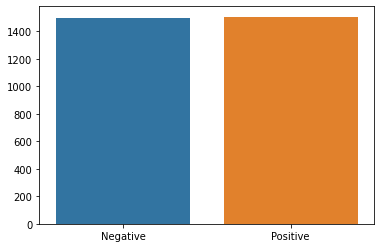

In [3]:
# Plot of data distribution
import seaborn as sns
sns.barplot(['Negative','Positive'],[len(Y_train[Y_train==0]),len(Y_train[Y_train==1])])

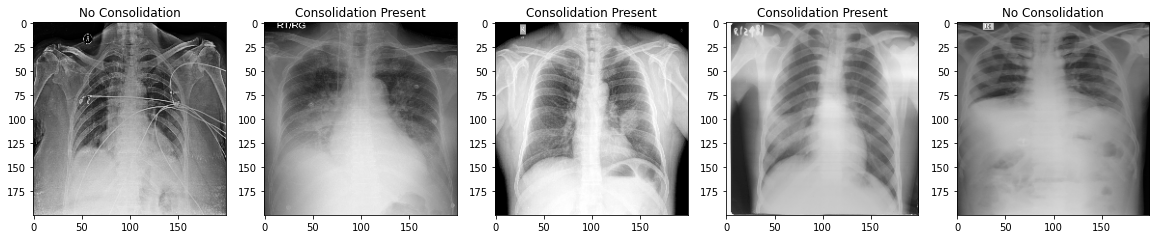

In [4]:
dict={1:'Consolidation Present',0:'No Consolidation'}
plt.figure(figsize=(20,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_train[i])
  plt.title(dict[Y_train[i]])

# Using Transfer Learning from VGG-16

In [5]:
# Loading the VGG NET model for transfer learning. 
#Since the XRAY images are very different from the Imagenet dataset, we will only be using the first few layers.

from keras import Input
new_input = Input(shape=(200, 200, 3)) 
base_model=VGG16(weights=(file_path+'/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),input_tensor=new_input,include_top=False, pooling='avg')

In [6]:
# Since X-Ray images and ImageNet images are very different we are only taking the first half of the model layers
model=Model(inputs=base_model.layers[0].input,outputs=base_model.get_layer('block3_pool').output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [9]:
# Creating a top layer

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D,Dense,Flatten
top_layer=Sequential()
top_layer.add(Conv2D(512,(3,3),input_shape=(25,25,256),padding='same',activation='relu'))
top_layer.add(Conv2D(512,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))
top_layer.add(Conv2D(1024,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))
top_layer.add(Conv2D(1024,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))

top_layer.add(Flatten())
top_layer.add(Dense(256,activation='relu'))
top_layer.add(Dense(64,activation='relu'))
top_layer.add(Dense(8,activation='relu'))
top_layer.add(Dense(2,activation='softmax'))

top_layer.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:

top_layer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 512)       1180160   
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 512)       2359808   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 512)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 1024)      4719616   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 1024)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 1024)       

# For Binary predictions to detect if a Xray has consolidation or not

In [ ]:
# from tqdm import tqdm
# vgg_embedding=[]
# for image in tqdm(x_train):
#   im=np.expand_dims(image,axis=0)
#   vgg_embedding.append(model.predict(im))



In [ ]:
# Getting embeddings from the existing model for the train images
from tqdm import tqdm

for train in np.array_split(x_train,10):
  embedding=[]
  for image in train:
    im=np.expand_dims(image,axis=0)
    embedding.append(model.predict(im))
  embedding=np.array(embedding)
  embedding=np.squeeze(embedding)
  target=np.array(y_train[0:len(embedding)])
  y_train=y_train[len(embedding):]
  top_layer.fit(embedding,target)
top_layer.save('top_layer.h5')

22/22 [==============================] - 9s 416ms/step - loss: 0.6716 - accuracy: 0.5930


In [ ]:
test_embedding=[]
for image in x_test[0:200]:
  im=np.expand_dims(image,axis=0)
  test_embedding.append(model.predict(im))
test_embedding=np.array(test_embedding)
test_embedding=np.squeeze(test_embedding)
test_target=np.array(y_test[0:200])


In [ ]:
# Getting embeddings from the existing model for the train images
from tqdm import tqdm

top_layer.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
for train in np.array_split(x_train,10):
  embedding=[]
  for image in train:
    im=np.expand_dims(image,axis=0)
    embedding.append(model.predict(im))
  embedding=np.array(embedding)
  embedding=np.squeeze(embedding)
  target=np.array(y_train[0:len(embedding)])
  y_train=y_train[len(embedding):]
  top_layer.fit(embedding,target,validation_data=(test_embedding,test_target))

22/22 [==============================] - 11s 496ms/step - loss: 0.6933 - accuracy: 0.4839 - val_loss: 0.6930 - val_accuracy: 0.5300


# Without transfer learning


In [ ]:
# Connecting to google drive and defining the file path
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/Covid Chest Xray'

Mounted at /content/drive


In [11]:
# Importing all the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Loading training data
train=np.load(file_path+'/train1.npz')
x_train=train['data']
Y_train=train['label']
y_train=np.zeros((len(Y_train),2))
for i,value in enumerate(Y_train):
  y_train[i][value]=1
del train

# Loading testing data
test=np.load(file_path+'/test1.npz')
x_test=test['data']
Y_test=test['label']
y_test=np.zeros((len(Y_test),2))
for i,value in enumerate(Y_test):
  y_test[i][value]=1
del test

In [12]:


# Creating a top layer

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(200,200,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())


model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2,activation='softmax'))

In [13]:
combine=[y_train,y_test]
for data in combine:
  zero=0
  one=0
  for value in data:
    if value[0]==1:
      zero+=1
    else:
      one+=1
  print(zero,' zeros and ',one, ' ones')

1494  zeros and  1506  ones
850  zeros and  860  ones


In [14]:
# Training
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks = [ModelCheckpoint('top_layer_best_weights_xray.h5', monitor='val_accuracy', verbose=1, save_best_only=True)]
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.5033
Epoch 1: val_accuracy improved from -inf to 0.55439, saving model to top_layer_best_weights_xray.h5
94/94 [==============================] - 26s 150ms/step - loss: 0.6987 - accuracy: 0.5033 - val_loss: 0.6924 - val_accuracy: 0.5544
Epoch 2/30
94/94 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5297
Epoch 2: val_accuracy did not improve from 0.55439
94/94 [==============================] - 12s 131ms/step - loss: 0.6914 - accuracy: 0.5297 - val_loss: 0.6872 - val_accuracy: 0.5029
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5457
Epoch 3: val_accuracy did not improve from 0.55439
94/94 [==============================] - 12s 130ms/step - loss: 0.6877 - accuracy: 0.5457 - val_loss: 0.6835 - val_accuracy: 0.5526
Epoch 4/30
94/94 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5490
Epoch 4: val_accuracy impr

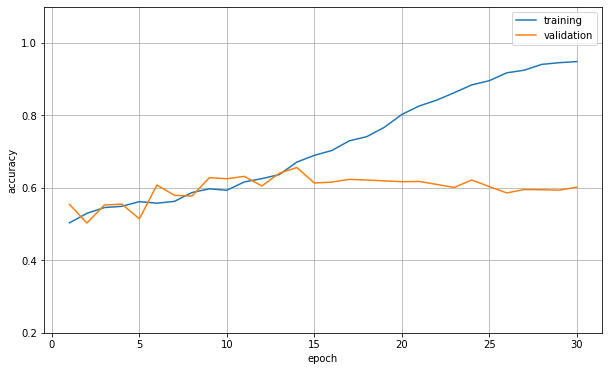

In [17]:
import pandas as pd
acc = pd.DataFrame({'epoch': range(1,31),
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.plot(x='epoch', figsize=(10,6), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.2,1.1]);


In [18]:
history.model.load_weights('top_layer_best_weights_xray.h5')
model=history.model

In [20]:
model.save(file_path+'/CNN_xray.h5')

# Prediction on test images

In [21]:
# del x_train
# del x_test
import tensorflow as tf
model=tf.keras.models.load_model(file_path+'/CNN_xray.h5')


In [22]:
# Loading training data
import numpy as np
test=np.load(file_path+'/test_images1.npz')
images=test['data']
filenames=test['filename']
predictions=model.predict(images)

In [23]:
labels=[]
for i in predictions:
  if i[0]==1:
    labels.append(0)
  else:
    labels.append(1)

In [25]:
import pandas as pd
prediction_df=pd.DataFrame()
prediction_df['Filename']=filenames
prediction_df['prediction']=labels
prediction_df.head()
prediction_df.to_csv('predictions.csv')

In [26]:
prediction_df.tail()

,Filename,prediction
3995,19693.png,1
3996,19599.png,0
3997,19631.png,1
3998,17765.png,0
3999,17275.png,0
